# 重回帰分析

## 分析の手順
1. 使用するデータセットを確認する  
   単回帰分析の結果を参照
2. 重回帰式を求めることに意義があるか確認する
3. 重回帰式を求める
4. 重回帰式の精度
5. 偏回帰係数の検定
6. 母回帰を推定する
7. 予測する

## 参考にする資料
- マンガでわかる統計学「回帰分析編」 高橋信 オーム社
- Pythonではじめる機械学習 オライリー・ジャパン
- http://publicjournal.hatenablog.com/entry/2018/01/28/194101
- http://blog.amedama.jp/entry/2016/12/23/193452
- https://to-kei.net/python/data-analysis/linearregression/#i-2

---

## １．使用するデータセットの確認
取得元：https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

### 分析の目的
**複数の説明変数から目的変数（サービス利用者数）を予測する**

想定できるビジネス上の課題・施策
- 省略

### 公開されていた情報
- アメリカのシェアサイクル（Capital Bikeshare）の履歴データ
- 会員登録していなくても利用することができる
- 天気情報は、http://www.freemeteo.com から取得している
- 対象の期間は、2011-01-01〜2012-12-31

### 想定できるビジネス上の考慮点
- サービス提供している地域でイベントがあると利用者の増加が見込まれる
- おそらく乗り捨て式のため、機会損失や自転車の再配置に伴うコストが発生する

### データセットを目検して気づいたこと
- 省略

---

## ２．データセットの加工

In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import statsmodels.api as smf
%matplotlib inline

In [2]:
# データのインポート
data_day = pd.read_csv('Bike_Sharing_Data_day.csv')
data_day.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


In [3]:
# 単相関係数を確認したいカラムを抽出する
drop_col = ['instant','dteday','season','yr','mnth','holiday','weekday','workingday','casual']
df = data_day.drop(drop_col,axis=1)

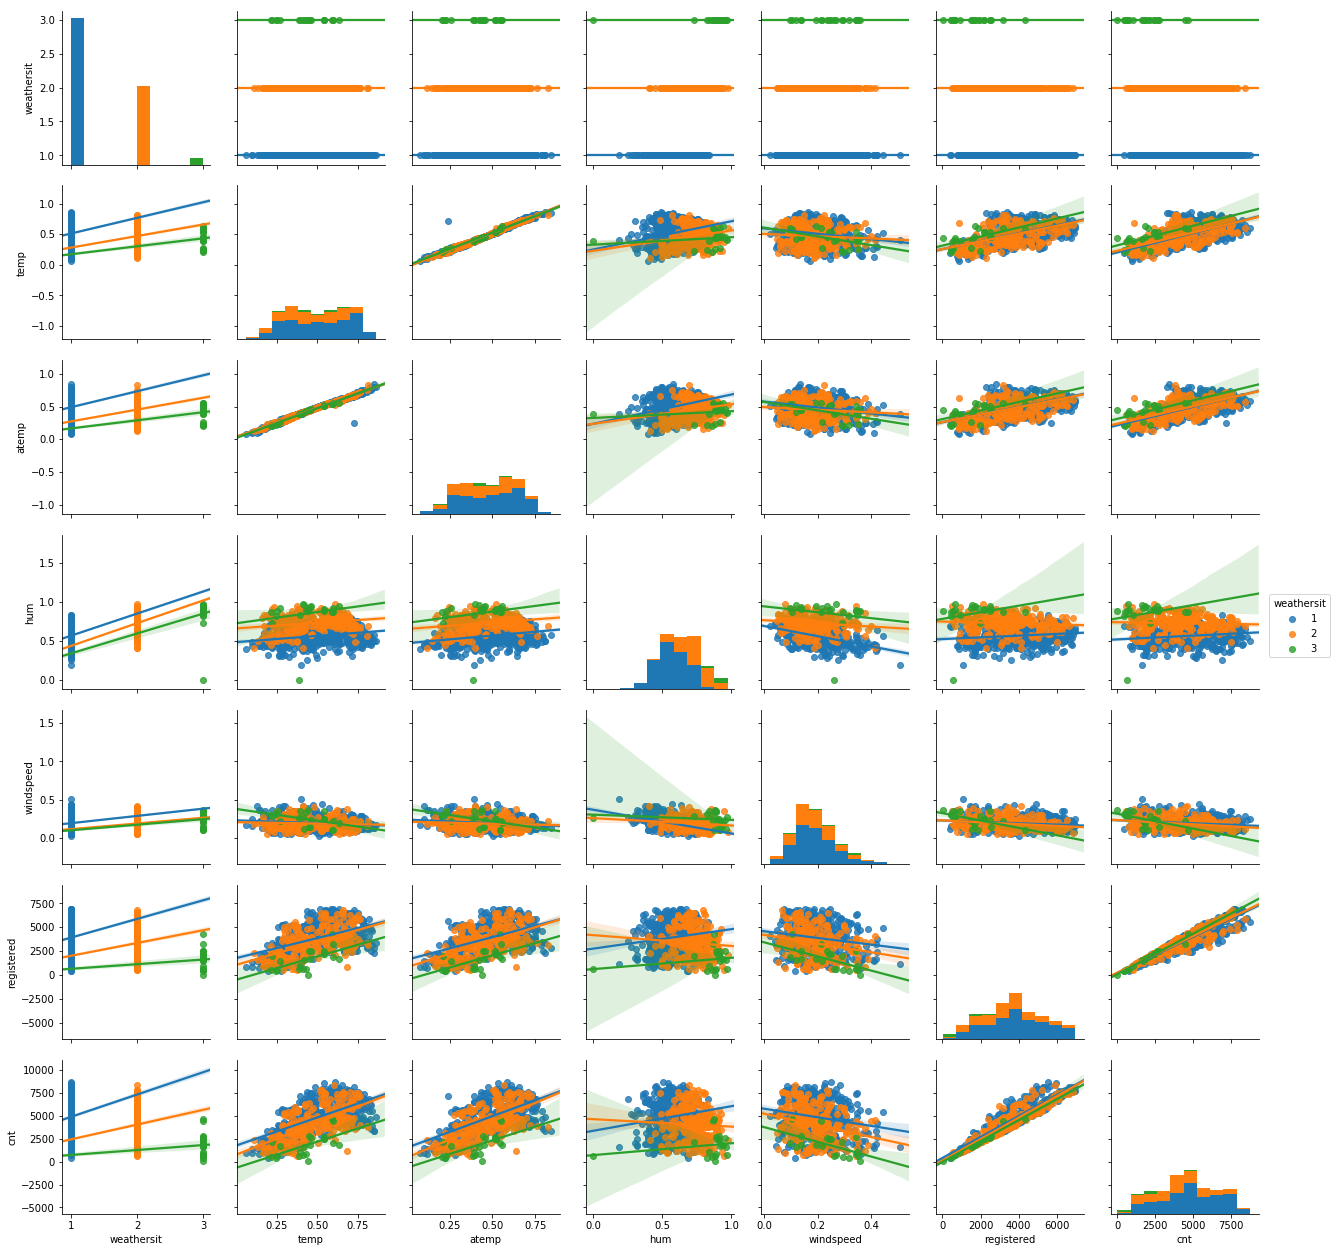

In [4]:
# 変数間の散布図と回帰直線を天候で色分けして確認する
sns.pairplot(df, kind = "reg", hue="weathersit")

In [5]:
# 総利用数との単相関係数を確認する
col_name = df.columns.values
for i in range(len(col_name)-1):
    x = df[col_name[i]]
    y = df['cnt']
    rxy = np.corrcoef(x,y)
    print("単相関係数:{}".format(rxy[0][1]), " :{}".format(col_name[i]))

単相関係数:-0.2973912388346636  :weathersit
単相関係数:0.6274940090334918  :temp
単相関係数:0.631065699849181  :atemp
単相関係数:-0.10065856213715531  :hum
単相関係数:-0.23454499742167  :windspeed
単相関係数:0.9455169158090364  :registered


標準化された気温(temp)、体感温度(temp)は、サービス利用者とのやや強い関係性が認められる  
会員登録済み利用者数は、全体のサービス利用者との関係性が非常に強い  
単回帰分析では、好天候のみに絞って単相関係数を確認したが、絞らない場合の方が単相関係数の絶対値は高かった

---

## ３．回帰式を求めることに意義があるか確認する

**精度の高い重回帰式を求めたいため、会員登録済み利用者と体感気温から全体のサービス利用者を予測する回帰式を求める。**  
会員登録済み利用者を事前に把握できるシステムではない（完全予約制ではない）ため、ビジネス的な意義はない。

In [6]:
# 説明変数と目的変数のみを抽出
plt3d_df = df[['weathersit','atemp','registered','cnt']]

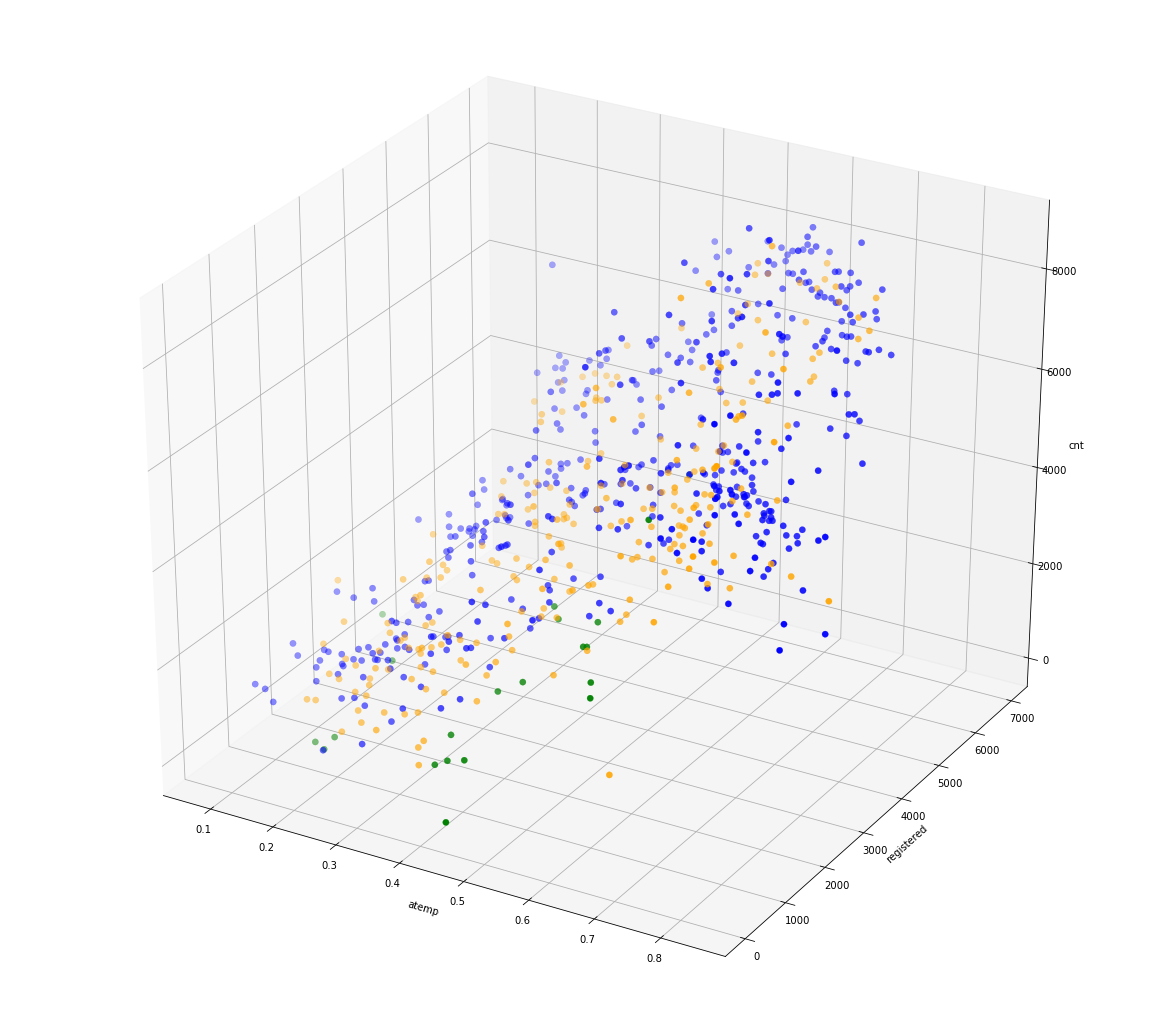

In [7]:
# 説明変数は会員登録済み利用者と体感気温の２項とし、分布をプロットして確認する
fig = plt.figure(figsize=(16, 14))
ax = Axes3D(fig)
color = ['blue','orange','green']

for i in range(3):
    plt_df = plt3d_df[plt3d_df['weathersit'] == i+1]
    xs = plt_df['atemp']
    ys = plt_df['registered']
    zs = plt_df['cnt']
    ax.scatter(xs, ys, zs, s=40, c=color[i], linewidth=0.25)

ax.set_xlabel("atemp")
ax.set_ylabel("registered")
ax.set_zlabel("cnt")

---

## ４．重回帰式を求める

In [8]:
# statsmodelsで偏回帰係数を求める
x = df[['atemp','registered']]
y = df['cnt']
model = smf.OLS(y, smf.add_constant(x))
result = model.fit()

a, b, c = result.params
print(result.params)
print("偏回帰係数1:{}".format(b))
print("偏回帰係数2:{}".format(c))
print("切片　　　 :{}".format(a))

const         -312.376537
atemp         1967.985179
registered       1.062095
dtype: float64
偏回帰係数1:1967.9851793050962
偏回帰係数2:1.06209537337593
切片　　　 :-312.3765370385164


重回帰式 $y=1967.99x_1+1.06x_2-312.38$ が得られた

---

## ５．重回帰式の精度

In [9]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     3834.
Date:                Wed, 25 Apr 2018   Prob (F-statistic):               0.00
Time:                        05:19:35   Log-Likelihood:                -5676.0
No. Observations:                 731   AIC:                         1.136e+04
Df Residuals:                     728   BIC:                         1.137e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -312.3765     67.820     -4.606      0.000      -445.524  -179.230
atemp       1967.9852    154.637     12.726      0.000      1664.397  2271.573
registered     1.0621      0.016     65.760      0.000         1.030     1.094
==============================================================================
Omnibus:                      211.864   Durbin-Watson:                   1.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              472.285
Skew:                           1.579   Prob(JB):                    2.78e-103
Kurtosis:                       5.353   Cond. No.                     3.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

重回帰分析の決定係数は、説明変数が増えるほど高くなるため、自由度調整済み寄与率を確認  
**自由度調整済み寄与率は、0.913と1.0に近く精度は高い**  
寄与率と自由度調整済み寄与率との乖離もない（説明変数が２つのみのため当然）

---

## ６．偏回帰係数の検定

**有意水準は、0.05とする**


**p値 ＜ 0.05　のため、統計的に有意である**

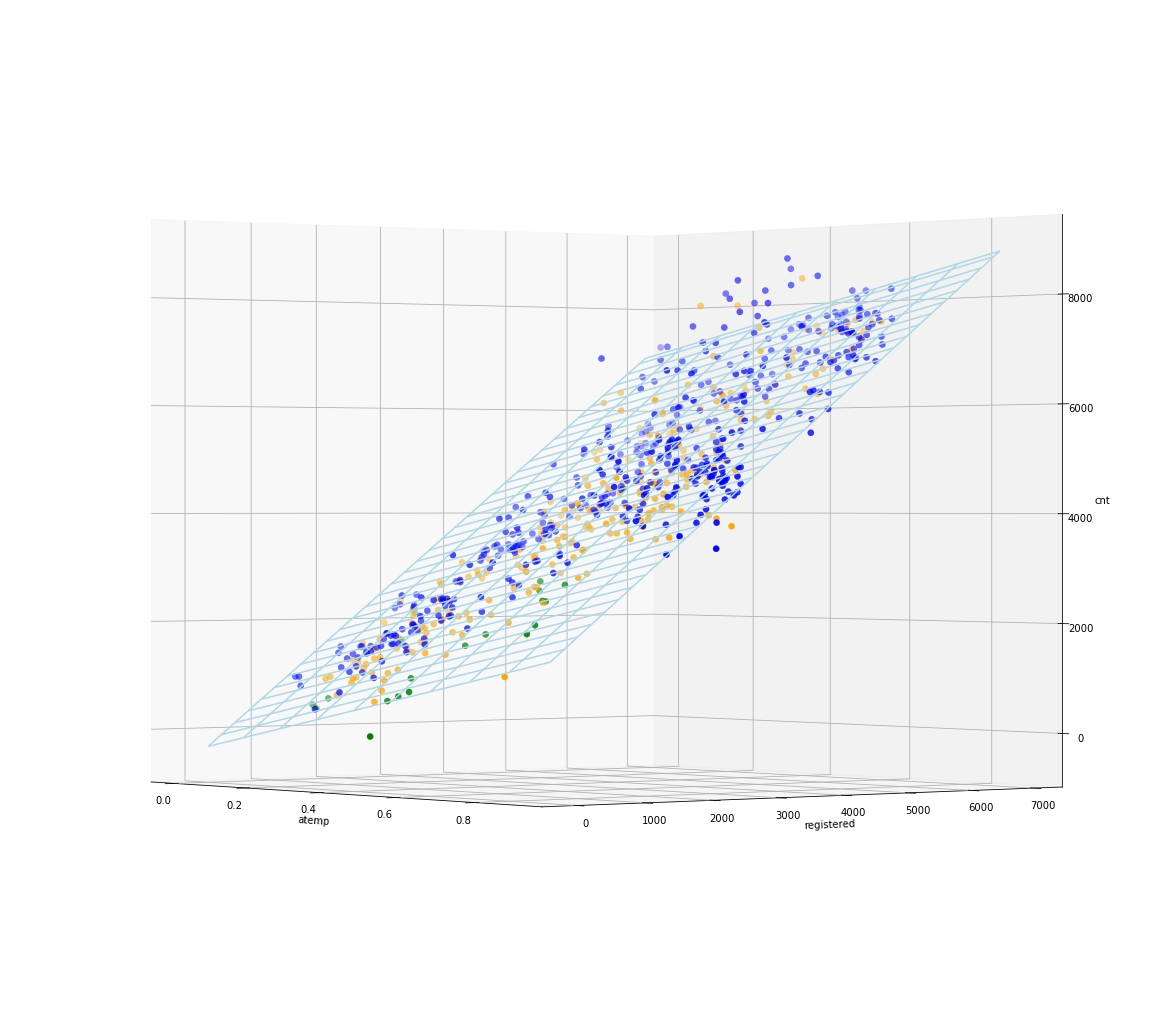

In [10]:
# 重回帰式により得られた多項式をプロット
fig = plt.figure(figsize=(16, 14))
ax = Axes3D(fig)

x = np.arange(0, 1, 0.1)
y = np.arange(0, 7000, 100)

X, Y = np.meshgrid(x, y)
Z = a + b*X + c*Y
ax.plot_wireframe(X,Y,Z, color='lightblue')

color = ['blue','orange','green']
plt3d_df = df[['weathersit','atemp','registered','cnt']]

for i in range(3):
    plt_df = plt3d_df[plt3d_df['weathersit'] == i+1]
    xs = plt_df['atemp']
    ys = plt_df['registered']
    zs = plt_df['cnt']
    ax.scatter(xs, ys, zs, s=40, c=color[i], linewidth=0.25)

ax.set_xlabel("atemp")
ax.set_ylabel("registered")
ax.set_zlabel("cnt")
ax.view_init(elev=0.0, azim=-38.0)

---